<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import nltk
import re
import spacy
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import f1_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingGridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Загрузка данных
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Text(0.5, 1.0, 'Распределение комментариев по классам токсичности')

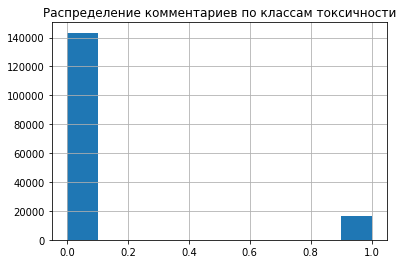

In [ ]:
# Проверим распределение целевого признака
data['toxic'].hist()
plt.title('Распределение комментариев по классам токсичности')

In [ ]:
data[data['toxic'] == 1].head(10)

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1
55,Stupid peace of shit stop deleting my stuff as...,1
56,=Tony Sidaway is obviously a fistfuckee. He lo...,1
58,My Band Page's deletion. You thought I was gon...,1


Многие токсичные комментарии пишутся в верхнем регистре, но это, пожалуй, не общее правило.

In [ ]:
data['is_upper'] = data['text'].str.isupper()

In [ ]:
print('Доля токсичных коментариев заглавными буквами: {0:.1%}'.format(
    data[data['is_upper'] == 1]['toxic'].mean()
))

Доля токсичных коментариев заглавными буквами: 66.7%


Перед обучением моделей подготовим признаки и целевой признак, запустив лемматизацию текстов.

In [ ]:
# Функция для лемматизации и очистки комментариев
def lemma_by_spacy(text):
    text = text.lower()
    doc = nlp(text)
    doc = " ".join([token.lemma_ for token in doc])
    doc = re.sub(r'[^a-zA-Z ]',' ',doc)
  
    return " ".join(doc.split())

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
#tqdm.pandas()
#data['text'] = data['text'].progress_apply(lambda x: lemmatize(clear_text(x)))

Выделим признаки для обучения моделей

In [ ]:
target = data['toxic']
features = data['text']

In [ ]:
tqdm.pandas()
lemma = features.progress_apply(lemma_by_spacy)

100%|██████████| 159571/159571 [17:51<00:00, 148.98it/s]


Разобьем датасет на обучающую и тестовую выборки. 

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(lemma, target, 
                                                                            test_size = 0.3, random_state = 12345)

Очистим тексты от стоп-слов и ненужных символов. Создадим счетчик, указав в нем стоп-слова

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform() для обучающей выборки. Сразу приведем данные выборок к формату Unicode.

In [ ]:
features_train = count_tf_idf.fit_transform(features_train)
#features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test)

In [ ]:
# Формы тренировочной и тестовой выборок
print(features_train.shape)
#print(features_valid.shape)
print(features_test.shape)

(111699, 124480)
(47872, 124480)


Ограничим количество кроссвалидаций до 3 для ускорения процесса и проверим показатели на модели логистической регрессии.

In [ ]:
classificator = LogisticRegression()
f1_train = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
print('F1 на кросс-валидации', f1_train)

F1 на кросс-валидации 0.7001447631887121


Классы разбалансированы. Уберем часть объектов бОльшего класса с помощью техники downsampling.

In [ ]:
data_train = data.iloc[target_train.index]

target_train_class_zero = data_train[data_train['toxic'] == 0]['toxic']
target_train_class_one = data_train[data_train['toxic'] == 1]['toxic']

target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12345)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

In [ ]:
features_train_downsample = data.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
features_train_downsample = count_tf_idf.transform(features_train_downsample['text']
                                                   .values.astype('U'))

In [ ]:
classificator = LogisticRegression()
f1_train_downsample = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=3, 
                      scoring='f1').mean()
print('F1 на кросс-валидации с уменьшением классов', f1_train_downsample)

F1 на кросс-валидации с уменьшением классов 0.8770088578293147


**Вывод**

В ходе предобработки путем токенизации и лемматизации подготовлены признаки для обучения. Выборка разделена на обучающую и тестовую в соотношении 70:30.

Судя по анализу метрики F1, стоит использовать классификатор с учетом веса классов.

## Обучение

Для обучения выберем следующие модели:

* Решающее дерево
* Логистическая регрессия
* Случайный лес
* CatBoost

### Решающее дерево

In [ ]:
# Подберем гиперпараметры с помощью HalvingGridSearchCV
classificator = DecisionTreeClassifier(class_weight = 'balanced')
param_grid = {"max_depth": [10, 101, 2]}
search = (HalvingGridSearchCV(classificator, param_grid, resource='max_features', max_resources=10, 
                              cv=3, random_state=12345))
search.fit(features_train, target_train)
search.best_params_

{'max_depth': 2, 'max_features': 9}

In [ ]:
f1_dt = search.best_score_
print(f1_dt)

0.3680158282527149


### Логистическая регрессия

In [ ]:
param_grid = {'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'],
              'C': [0.1, 1, 10],
              'class_weight': ['balanced']}
search = (HalvingGridSearchCV(LogisticRegression(), param_grid,
                            scoring = 'f1', cv=3, random_state=12345))
search.fit(features_train, target_train)
search.best_params_

{'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}

In [ ]:
f1_lr = search.best_score_
print(f1_lr)

0.7501033090205939


### Случайный лес

In [ ]:
param_grid = {'n_estimators':[10, 200, 10],
              'max_depth':[2, 100, 10],
              'class_weight': ['balanced']}
search = (HalvingGridSearchCV(RandomForestClassifier(), param_grid, 
                            scoring = 'f1', cv=3, random_state=12345))
search.fit(features_train, target_train)
search.best_params_

{'class_weight': 'balanced', 'max_depth': 100, 'n_estimators': 200}

In [ ]:
f1_rf = search.best_score_
print(f1_rf)

0.5469888772785895


### Модель CatBoost

In [ ]:
param_grid = {'iterations':[100, 200, 50],
              'learning_rate':[0.1, 1.0, 0.2]}
search = (HalvingGridSearchCV(CatBoostClassifier(), param_grid, verbose = 20,
                            scoring = 'f1', cv=3, random_state=12345))
search.fit(features_train, target_train)
search.best_params_

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 12411
max_resources_: 111699
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 12411
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START iterations=100, learning_rate=0.1...........................
0:	learn: 0.5999579	total: 355ms	remaining: 35.1s
1:	learn: 0.5197036	total: 576ms	remaining: 28.2s
2:	learn: 0.4601355	total: 798ms	remaining: 25.8s
3:	learn: 0.4151490	total: 1.02s	remaining: 24.4s
4:	learn: 0.3812665	total: 1.24s	remaining: 23.6s
5:	learn: 0.3550014	total: 1.46s	remaining: 22.9s
6:	learn: 0.3330446	total: 1.68s	remaining: 22.3s
7:	learn: 0.3140495	total: 1.91s	remaining: 22s
8:	learn: 0.2993969	total: 2.15s	remaining: 21.7s
9:	learn: 0.2889785	total: 2.38s	remaining: 21.4s
10:	learn: 0.2793645	total: 2.61s	remaining: 21.1s
11:	learn: 0.2708005	total: 2.83s	remaining: 20.7s
12:	learn: 0.2625543	total: 3.05s	remaining: 20.4s
13:

{'iterations': 50, 'learning_rate': 1.0}

In [ ]:
f1_cb = search.best_score_
print(f1_cb)

0.7410210032652431


Сведем в единой таблице данные валидации обученных моделей.

In [ ]:
index = ['Решающее дерево',
         'Логистическая регрессия',
         'Случайный лес',
         'CatBoost']
data = {'F1 на кросс-валидации':[f1_dt, f1_lr, f1_rf, f1_cb]}

scores = pd.DataFrame(data=data, index=index)
scores['Выполнение условия'] = scores['F1 на кросс-валидации'] > 0.75
scores

,F1 на кросс-валидации,Выполнение условия
Решающее дерево,0.368016,False
Логистическая регрессия,0.750103,True
Случайный лес,0.546989,False
CatBoost,0.741021,False


In [ ]:
model = LogisticRegression(class_weight = 'balanced', C = 1, solver = 'lbfgs')
model.fit(features_train, target_train)
print('F1 лучшей модели на тестовых данных:', f1_score(target_test, model.predict(features_test)))

F1 лучшей модели на тестовых данных: 0.7531297847428624


## Выводы

В ходе работы над проектом выполнены следующие шаги:

* Исходные данные подготовлены к обучению с использованием токенизации и лемматизации текстов
* Датасет поделен на обучающую и тестовую выборки в отношении 70:30
* Обучены модели решающего дерева, логистической регрессии, случайного леса и CatBoost с балансировкой классов. 

Лучший показатель качества по метрике F1=0.75 показала модель логистической регрессии. Данный результат подтверждается при работе модели на тестовых данных.